In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem

from itertools import product

# Set seaborn style for nicer aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.autolayout': True}) 

In [3]:
data_dir = "../../data/replication_gcn/final_model_test/benchmark-models"
file_pattern = r"gcn_(regression|classification)_(gcn1|gcn2|gcn3)_lr0001_dim100_predictions_test"

In [4]:
# List to store individual DataFrames
dataframes = []

# Loop through each file in the directory
for filename in os.listdir(data_dir):
    match = re.match(file_pattern, filename)
    if match:
        task, iteration = match.groups()
        
        # Read the CSV file
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path)
        
        # Add new columns based on parsed filename values
        df['model'] = "GCN " + task
        df['iteration'] = re.sub(r"\D", "", iteration)
        
        # Append the DataFrame to the list
        dataframes.append(df)

In [5]:
# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df = combined_df[['smiles', 'prediction_neglogld50', 'prediction_mgkg', 'prediction_epa', 
                           'actual_neglogld50', 'actual_mgkg', 'actual_epa', 'model', 'iteration']]
combined_df.to_csv('../../data/replication_gcn/final_model_test/all_gcn_predictions.csv',index=False)

In [6]:
def calculate_epa_accuracies(df):
    df.loc[:, 'accuracy'] = (df['actual_epa'] == df['prediction_epa']).astype(float)

    # Group by model and gcn, calculate mean and standard deviation of accuracy
    combined_df = df.groupby(['model','iteration']).agg(
        mean_accuracy=('accuracy', 'mean'),
        sd_accuracy=('accuracy', 'std')
    ).reset_index()

    return pd.DataFrame(combined_df)

In [7]:
# 1. EPA  Accuracies
accuracy_summary = calculate_epa_accuracies(combined_df)
accuracy_summary

,model,iteration,mean_accuracy,sd_accuracy
0,GCN classification,1,0.608170,0.488261
1,GCN classification,2,0.600667,0.489863
2,GCN classification,3,0.609837,0.487888
3,GCN regression,1,0.592330,0.491504
4,GCN regression,2,0.566486,0.495663
5,GCN regression,3,0.599833,0.490034


<Figure size 1500x600 with 0 Axes>

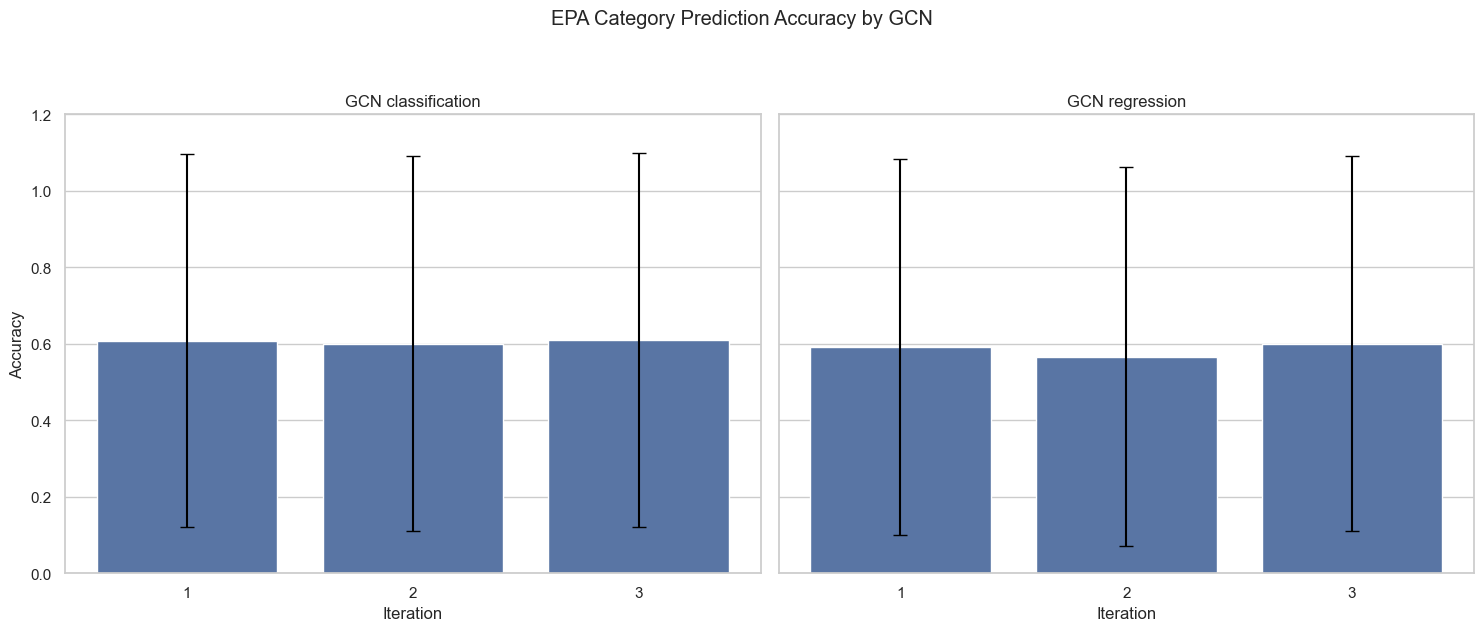

In [8]:
models = accuracy_summary['model'].unique()

plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(1, len(models), figsize=(15, 6), sharey=True)
fig.suptitle('EPA Category Prediction Accuracy by GCN', y=1.05)


if len(models) == 1:
    axes = [axes]

# Loop through each model
for i, model in enumerate(models):
    model_data = accuracy_summary[accuracy_summary['model'] == model]
    
    # Bar plot for the model with error bars
    sns.barplot(
        data=model_data, 
        x='iteration', y='mean_accuracy', 
        ax=axes[i], 
        capsize=0.1
    )
    axes[i].errorbar(
        x=range(len(model_data)), 
        y=model_data['mean_accuracy'], 
        yerr=model_data['sd_accuracy'], 
        fmt='none', 
        c='black', 
        capsize=5
    )
    # Set labels and title dynamically
    axes[i].set_ylabel('Accuracy')
    axes[i].set_xlabel('Iteration')
    axes[i].set_title(f'{model}')
    axes[i].set_ylim(0.0, 1.2)

plt.tight_layout()
plt.show()

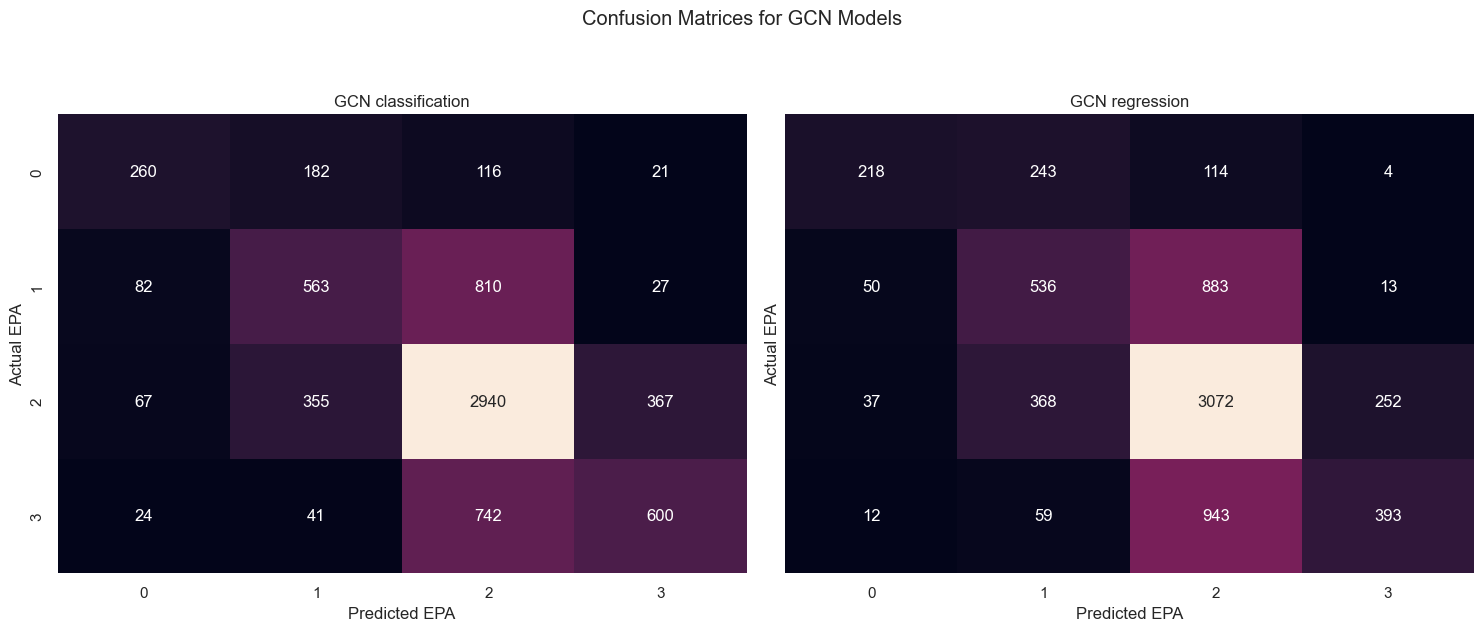

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get unique models from the data structure
models = combined_df['model'].unique()

# Step 2: Set up subplots based on the number of models
fig, axes = plt.subplots(1, len(models), figsize=(15, 6), sharey=True)
fig.suptitle('Confusion Matrices for GCN Models', y=1.05)

# Ensure axes is iterable (needed when there's only one model)
if len(models) == 1:
    axes = [axes]

# Loop through each model to compute and plot the confusion matrix
for i, model in enumerate(models):
    # Filter the data for the current model
    model_data = combined_df[combined_df['model'] == model]
    
    # Compute the confusion matrix
    cm = confusion_matrix(model_data['actual_epa'], model_data['prediction_epa'])
    
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt="d", ax=axes[i], cbar=False)
    axes[i].set_title(f'{model}')
    axes[i].set_xlabel('Predicted EPA')
    axes[i].set_ylabel('Actual EPA')

plt.tight_layout()
plt.show()

## Voting system

In [22]:
def get_mode(series):
    mode = series.mode()
    return mode[0] if not mode.empty else None

# Group by 'smiles' and 'model' and calculate the mode of 'prediction epa'
grouped_df = combined_df.groupby(['smiles', 'model']).apply(
    lambda group: group.assign(prediction_epa_mode=get_mode(group['prediction_epa']))
)

# Drop duplicates to get one row per 'smiles' and 'model' with the mode value
result_df = grouped_df.drop_duplicates(subset=['smiles', 'model'])

# Select only relevant columns
result_df = result_df[['model', 'prediction_epa', 'actual_epa']]

C:\Users\xalvna\AppData\Local\Temp\ipykernel_26296\1635866863.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = combined_df.groupby(['smiles', 'model']).apply(


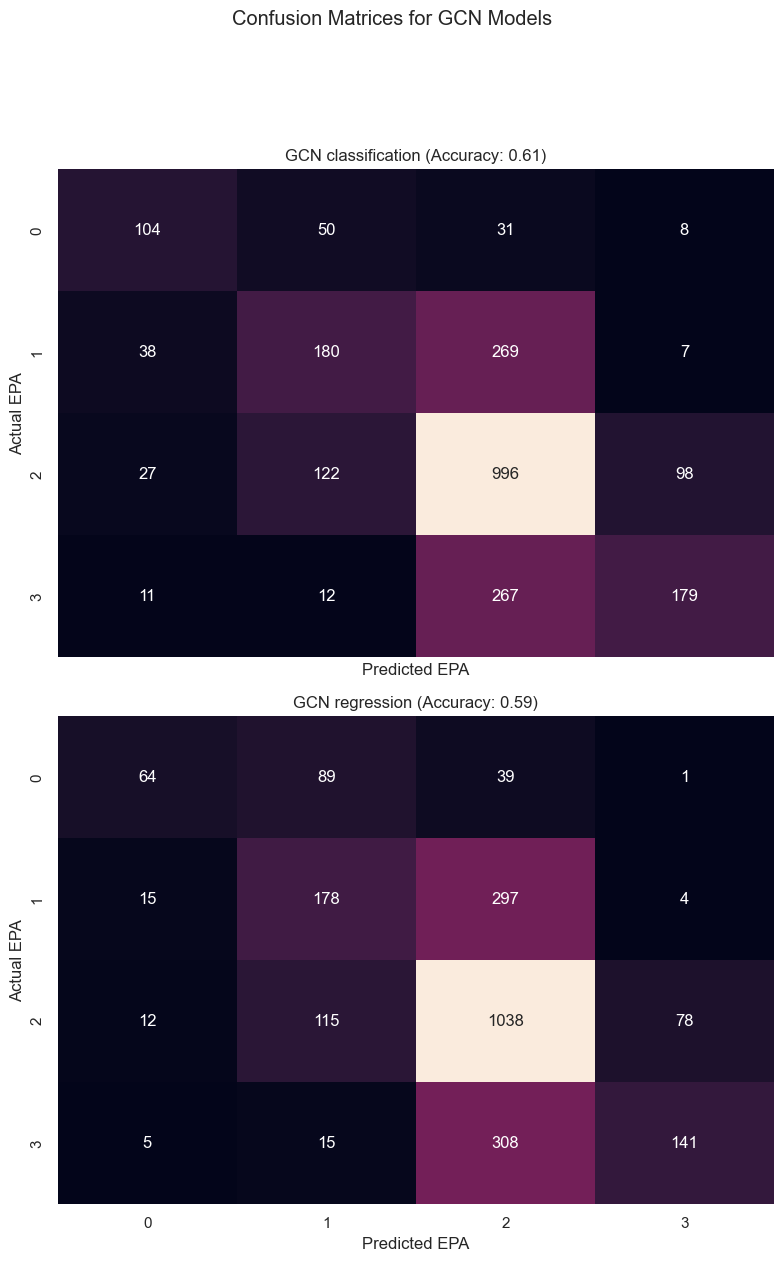

In [ ]:
models = result_df['model'].unique()

# Create subplots, one row per model
fig, axes = plt.subplots(len(models), 1, figsize=(8, 6 * len(models)), sharex=True)
fig.suptitle('Confusion Matrices for GCN Models', y=1.05)

# Ensure axes is iterable (needed when there's only one model)
if len(models) == 1:
    axes = [axes]

# Loop through each model to compute and plot the confusion matrix
for i, model in enumerate(models):
    # Filter the data for the current model
    model_data = result_df[result_df['model'] == model]
    
    # Aggregate data for the confusion matrix
    aggregated_data = model_data.groupby(['smiles', 'actual_epa'])['prediction_epa'].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None
    ).reset_index()
    
    # Compute the confusion matrix
    cm = confusion_matrix(aggregated_data['actual_epa'], aggregated_data['prediction_epa'])
    
    # Compute accuracy
    accuracy = accuracy_score(aggregated_data['actual_epa'], aggregated_data['prediction_epa'])
    
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt="d", ax=axes[i], cbar=False)
    axes[i].set_title(f'{model} (Accuracy: {accuracy:.2f})')
    axes[i].set_xlabel('Predicted EPA')
    axes[i].set_ylabel('Actual EPA')

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit titles
plt.show()

In [11]:
# Confusion matrices when PFAS
ldtoxdb = pd.read_csv("../../data/full_dataset.csv")
ldtoxdb = ldtoxdb[['smi', 'is_pfas_like']]

pfas_df = pd.merge(combined_df, ldtoxdb, left_on='smiles', right_on='smi', how='left')
pfas_df = pfas_df[pfas_df['is_pfas_like']==True]


Accuracy of GCN classification on PFAS
                model iteration  mean_accuracy  sd_accuracy
0  GCN classification         1           0.36     0.484873
1  GCN classification         2           0.28     0.453557
2  GCN classification         3           0.46     0.503457

Accuracy of GCN regression on PFAS
            model iteration  mean_accuracy  sd_accuracy
0  GCN regression         1           0.30     0.462910
1  GCN regression         2           0.34     0.478518
2  GCN regression         3           0.44     0.501427


<Figure size 1500x600 with 0 Axes>

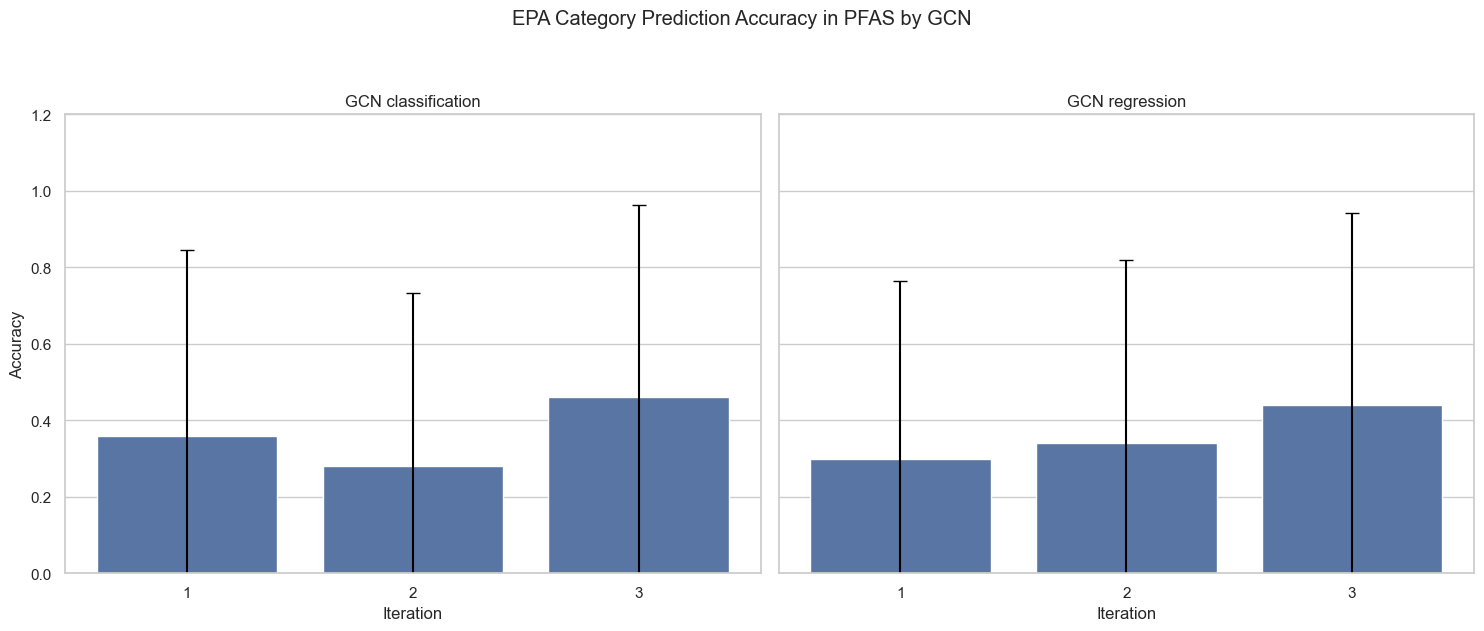

In [12]:
ldtoxdb = pd.read_csv("../../data/full_dataset.csv")
ldtoxdb = ldtoxdb[['smi', 'is_pfas_like']]

# Merge with combined_df 
pfas_df = pd.merge(combined_df, ldtoxdb, left_on='smiles', right_on='smi', how='left')
pfas_df = pfas_df[pfas_df['is_pfas_like'] == True]

models = pfas_df['model'].unique()

accuracy_summaries = {}
for model in models:
    model_data = pfas_df[pfas_df['model'] == model]
    accuracy_summaries[model] = calculate_epa_accuracies(model_data)

# Print accuracies
for model, summary in accuracy_summaries.items():
    print(f'\nAccuracy of {model} on PFAS')
    print(summary)

# Plots
plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(1, len(models), figsize=(15, 6), sharey=True)
fig.suptitle('EPA Category Prediction Accuracy in PFAS by GCN', y=1.05)

if len(models) == 1:
    axes = [axes]

for i, model in enumerate(models):
    model_summary = accuracy_summaries[model]
    
    # Plot with error bars
    sns.barplot(
        data=model_summary, 
        x='iteration', y='mean_accuracy', 
        ax=axes[i], 
        capsize=0.1
    )
    axes[i].errorbar(
        x=range(len(model_summary)), 
        y=model_summary['mean_accuracy'], 
        yerr=model_summary['sd_accuracy'], 
        fmt='none', 
        c='black', 
        capsize=5
    )

    axes[i].set_ylabel('Accuracy')
    axes[i].set_xlabel('Iteration')
    axes[i].set_title(model)
    axes[i].set_ylim(0.0, 1.2)

plt.tight_layout()
plt.show()

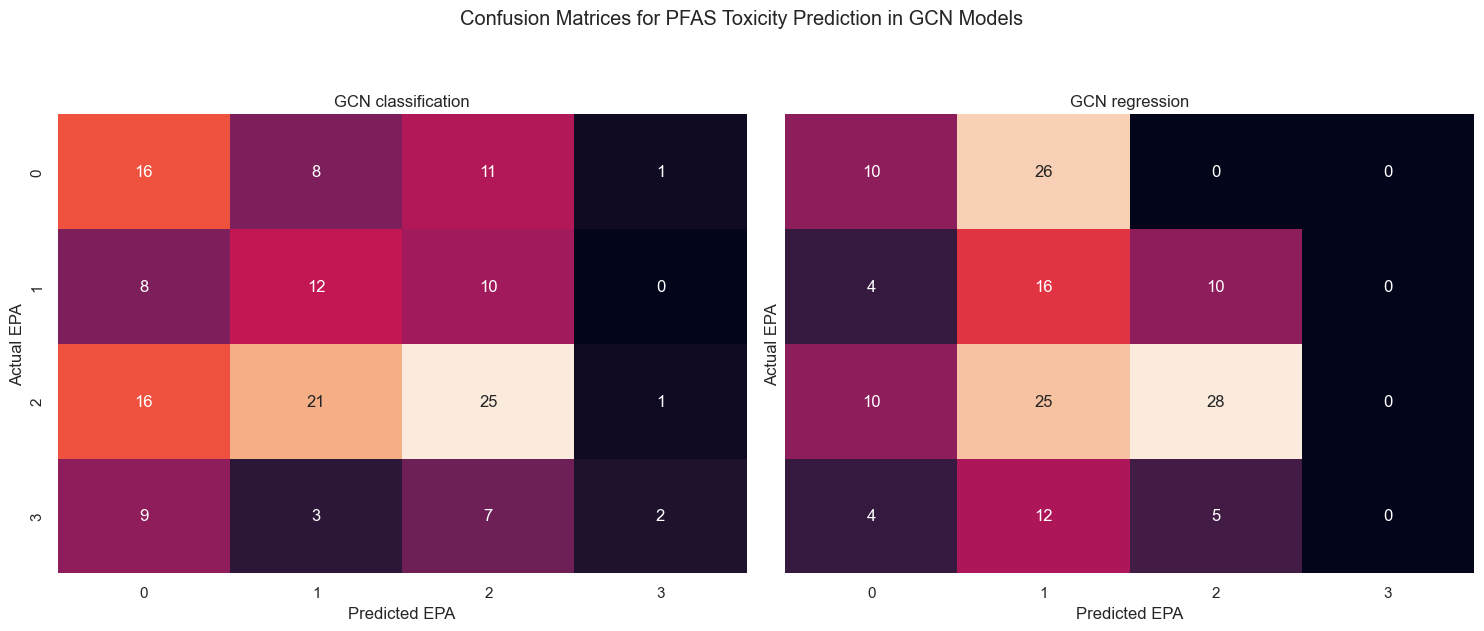

In [13]:
# Diff models
models = pfas_df['model'].unique()

# Set up subplots based on the number of models dynamically
fig, axes = plt.subplots(1, len(models), figsize=(15, 6), sharey=True)
fig.suptitle('Confusion Matrices for PFAS Toxicity Prediction in GCN Models', y=1.05)

if len(models) == 1:
    axes = [axes]

# Loops
for i, model in enumerate(models):
    # Filter data for the current model
    model_data = pfas_df[pfas_df['model'] == model]
    
    # Compute the confusion matrix
    cm = confusion_matrix(model_data['actual_epa'], model_data['prediction_epa'])
    
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt="d", ax=axes[i], cbar=False)
    axes[i].set_title(model)
    axes[i].set_xlabel('Predicted EPA')
    axes[i].set_ylabel('Actual EPA')

plt.tight_layout()
plt.show()
